In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
def euler_approximation(y_i, b, delta, sigma, delta_w):
  y = y_i + b * delta + sigma * delta_w
  return y

def milstein_scheme1(y_i, b, delta, sigma, sigma_x, delta_w):
  y = (y_i + b * delta + sigma * delta_w 
       + 1/2 * sigma * sigma_x * (delta_w**2 - delta)
      )
  return y

def milstein_scheme2(delta_w, b, b_x, sigma, sigma_x, b_xx, sigma_xx, y_i, delta, z):
  y = (y_i
       + (b - 1/2 * sigma * sigma_x) * delta
       + sigma * z * np.sqrt(delta)
       + 1/2 * sigma * sigma_x * delta * z**2
       + delta**(3/2) * (1/2 * b * sigma_x + 1/2 * b_x * sigma + 1/4 * sigma**2 * sigma_xx) * z
       + delta**2 * (1/2 * b * b_x + 1/4 * b_xx * sigma**2)
       )
  return y

def y_wave(y, b, delta, sigma, z):
  return y + b * delta + sigma * np.sqrt(delta) * z

def b_wave(b, nu, sigma, sigma_x):
  return b - nu * sigma * sigma_x

def predictor_corrector_method(y, delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z, nu, alpha):
  b_wave_y = b_wave(b, nu, sigma, sigma_x)
  b_wave_y_wave = b_wave(b_y_wave, nu, sigma_y_wave, sigma_y_wave_x)
  
  y_i = (y + (alpha * b_wave_y_wave + (1 - alpha) * b_wave_y) * delta
         + (nu * sigma_y_wave + (1 - nu) * sigma) * np.sqrt(delta) * z
        )
  return y_i

def kloden_platen_schurz_sorensen_method(y, b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w, z):
  delta_u = z * 1/3 * delta**3
  y_i = (y
         + b * delta 
         + sigma * delta_w
         + 1/2 * sigma * sigma_x * (delta_w**2 - delta)
         + sigma * b_x * delta_u
         + 1/2 * (b * b_x + 1/2 * sigma**2 * b_xx) * delta**2
         + (b * sigma_x + 1/2 * sigma**2 * sigma_xx) * (delta_w * delta - delta_u)
         + 1/2 * sigma * s * (1/3 * delta_w**2 - delta) * delta_w
         )
  return y_i

def Ornstein_Uhlenbeck_process(x0, N, T, theta, t, sigma, delta, delta_w, z, approximation_method):
  x = np.zeros(N)
  x[0] = x0
  delta = T / N

  nu = 0.5
  alpha = 0.5

  for i in range(1, N):
    b = - theta * x[i-1]
    b_x = - theta
    b_xx = 0

    sigma_x = 0
    sigma_xx = 0

    if approximation_method == "euler":
      x[i] = euler_approximation(x[i-1], b, delta, sigma, delta_w[i])
    elif approximation_method == "milstein1":
      x[i] = milstein_scheme1(x[i-1], b, delta, sigma, sigma_x, delta_w[i])
    elif approximation_method == "milstein2":
      x[i] = milstein_scheme2(delta_w[i], b, b_x, sigma, sigma_x, b_xx, sigma_xx, x[i-1], delta, z[i])
    elif approximation_method == "predictor-corrector":
      y_wave_value = y_wave(x[i-1], b, delta, sigma, z[i])
      b_y_wave = - theta * y_wave_value
      sigma_y_wave = sigma
      sigma_y_wave_x = sigma_x
      x[i] = predictor_corrector_method(x[i-1], delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z[i], nu, alpha)
    elif approximation_method == "kloden-platen-schurz-sorensen":
      s = 0
      x[i] = kloden_platen_schurz_sorensen_method(x[i-1], b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w[i], z[i])

  if approximation_method == "euler":
    plt.plot(t, x, label = 'OU (euler)')
  elif approximation_method == "milstein1":
    plt.plot(t, x, label = 'OU (milstein1)')
  elif approximation_method == "milstein2":
    plt.plot(t, x, label = 'OU (milstein2)')
  elif approximation_method == "predictor-corrector":
    plt.plot(t, x, label = 'OU (predictor-corrector)')
  elif approximation_method == "kloden-platen-schurz-sorensen":
    plt.plot(t, x, label = 'OU (kpss)')

def Cox_Ingersoll_Ross_process(theta1, theta2, theta3, x0, N, T, t, delta, delta_w, z, approximation_method):
  x = np.zeros(N)
  x[0] = x0
  delta = T / N

  nu = 0.5
  alpha = 0.5

  for i in range(1, N):
    b = theta1 - theta2 * x[i-1]
    b_x = - theta2
    b_xx = 0

    sigma = theta3 * (x[i-1])**(1/2)
    sigma_x = 1/2 * theta3 * (x[i-1])**(-1/2)
    sigma_xx = - 1/4  * theta3 * (x[i-1])**(-3/2)

    if approximation_method == "euler":
      x[i] = euler_approximation(x[i-1], b, delta, sigma, delta_w[i])
    elif approximation_method == "milstein1":
      x[i] = milstein_scheme1(x[i-1], b, delta, sigma, sigma_x, delta_w[i])
    elif approximation_method == "milstein2":
      x[i] = milstein_scheme2(delta_w[i], b, b_x, sigma, sigma_x, b_xx, sigma_xx, x[i-1], delta, z[i])
    elif approximation_method == "predictor-corrector":
      y_wave_value = y_wave(x[i-1], b, delta, sigma, z[i])
      b_y_wave = theta1 - theta2 * y_wave_value
      sigma_y_wave = theta3 * y_wave_value**(1/2)
      sigma_y_wave_x = 1/2 * theta3 * y_wave_value**(-1/2)
      x[i] = predictor_corrector_method(x[i-1], delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z[i], nu, alpha)
    elif approximation_method == "kloden-platen-schurz-sorensen":
      s = 0
      x[i] = kloden_platen_schurz_sorensen_method(x[i-1], b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w[i], z[i])

  if approximation_method == "euler":
    plt.plot(t, x, label = 'CIR (euler)')
  elif approximation_method == "milstein1":
    plt.plot(t, x, label = 'CIR (milstein1)')
  elif approximation_method == "milstein2":
    plt.plot(t, x, label = 'CIR (milstein2)')
  elif approximation_method == "predictor-corrector":
    plt.plot(t, x, label = 'CIR (predictor-corrector)')
  elif approximation_method == "kloden-platen-schurz-sorensen":
    plt.plot(t, x, label = 'CIR (kpss)')
  

def Black_Scholes_Merton_process(theta1, theta2, x0, N, T, t, delta, delta_w, z, approximation_method):
  x = np.zeros(N)
  x[0] = x0

  nu = 0.5
  alpha = 0.5
  for i in range(1, N):
    b = theta1 * x[i-1]
    b_x = theta1
    b_xx = 0

    sigma = theta2 * x[i-1]
    sigma_x = theta2
    sigma_xx = 0

    if approximation_method == "euler":
      x[i] = euler_approximation(x[i-1], b, delta, sigma, delta_w[i])
    elif approximation_method == "milstein1":
      x[i] = milstein_scheme1(x[i-1], b, delta, sigma, sigma_x, delta_w[i])
    elif approximation_method == "milstein2":
      x[i] = milstein_scheme2(delta_w[i], b, b_x, sigma, sigma_x, b_xx, sigma_xx, x[i-1], delta, z[i])
    elif approximation_method == "predictor-corrector":
      y_wave_value = y_wave(x[i-1], b, delta, sigma, z[i])
      b_y_wave = theta1 * y_wave_value
      sigma_y_wave = theta2 * y_wave(x[i-1], b, delta, sigma, z[i])
      sigma_y_wave_x = sigma_x
      x[i] = predictor_corrector_method(x[i-1], delta, b, b_y_wave, sigma, sigma_x, sigma_y_wave, sigma_y_wave_x, z[i], nu, alpha)
    elif approximation_method == "kloden-platen-schurz-sorensen":
      s = theta2**2
      x[i] = kloden_platen_schurz_sorensen_method(x[i-1], b, b_x, b_xx, sigma, sigma_x, sigma_xx, s, delta, delta_w[i], z[i])
      

  if approximation_method == "euler":
    plt.plot(t, x, label = 'BSM (euler)')
  elif approximation_method == "milstein1":
    plt.plot(t, x, label = 'BSM (milstein1)')
  elif approximation_method == "milstein2":
    plt.plot(t, x, label = 'BSM (milstein2)')
  elif approximation_method == "predictor-corrector":
    plt.plot(t, x, label = 'BSM (predictor-corrector)')
  elif approximation_method == "kloden-platen-schurz-sorensen":
    plt.plot(t, x, label = 'BSM (kpss)')
  


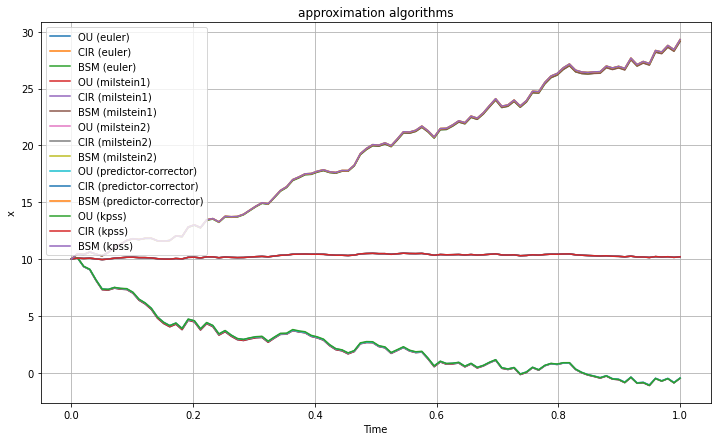

In [94]:
x0 = 10
sigma = 3.5
N = 100
T = 1
t = np.linspace(0, T, N)

delta = T / N
delta_w = np.zeros(N)

z = np.random.normal(0, 1, N)
delta_w = z * np.sqrt(delta)

plt.figure(figsize=(12, 7))

approximation_algorithms = ["euler", "milstein1", "milstein2", "predictor-corrector", "kloden-platen-schurz-sorensen"]

for algorithm in approximation_algorithms:
  theta = 5
  Ornstein_Uhlenbeck_process(x0, N, T, theta, t, sigma, delta, delta_w, z, algorithm)

  theta1 = 2
  theta2 = 0.2
  theta3 = 0.15
  Cox_Ingersoll_Ross_process(theta1, theta2, theta3, x0, N, T, t, delta, delta_w, z, algorithm)


  theta1 = 1
  theta2 = 0.2
  Black_Scholes_Merton_process(theta1, theta2, x0, N, T, t, delta, delta_w, z, algorithm)


plt.grid()
plt.title('approximation algorithms')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.show()